In [2]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from learning_utilities import *

Setting environment for Gordon


No vtk
Cannot import mxnet.


In [3]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
from xgboost.sklearn import XGBClassifier

In [4]:
setting = 8
setting_dir = os.path.join(os.path.join(CLF_ROOTDIR, 'setting_%d' % setting))

In [5]:
structures_to_sample = all_known_structures

negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

margins_to_sample = [200, 500]
surround_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
                             for m in margins_to_sample
                             for s in structures_to_sample 
                             for surr_l in structures_to_sample + ['noclass'] 
                             if surr_l != s]

labels_to_sample = structures_to_sample + negative_labels_to_sample + surround_labels_to_sample + ['noclass']

# Extract Training Data

In [ ]:
# Extract training features - random subset

training_addresses = defaultdict(list)

labels_found = set([])

for stack in all_annotated_nissl_stacks:
# for stack in ['MD635']:
    annotation_grid_indices_fn = os.path.join(ANNOTATION_ROOTDIR, stack, stack + '_annotation_grid_indices.h5')
    label_gridIndices = read_hdf(annotation_grid_indices_fn, 'grid_indices')
    
    labels_this_stack = set(label_gridIndices.index) & set(labels_to_sample)
    labels_found = labels_found | labels_this_stack
    
    training_addresses_sec_idx = sample_locations(label_gridIndices, labels_this_stack, 
                                                  num_samples_per_landmark=1000)
    
    for name, addresses in training_addresses_sec_idx.iteritems():
        training_addresses[name] += [(stack, ) + addr for addr in addresses]
        
training_addresses.default_factory = None
        
# sampled_addresses = {name_u: np.array(addresses) for name_u, addresses in sampled_addresses.iteritems()}

In [ ]:
training_features = apply_function_to_dict(addresses_to_features, training_addresses)

In [ ]:
# Remove addresses whose features are None
for name in labels_found:
    valid = [(ftr, addr) for ftr, addr in zip(training_features[name], training_addresses[name])
                if ftr is not None]
    res = zip(*valid)
    training_features[name] = np.array(res[0])
    training_addresses[name] = res[1]

In [ ]:
for name in sorted(training_addresses.iterkeys()):
    print name, len(training_addresses[name])

In [ ]:
train_feat_dir = create_if_not_exists(os.path.join(setting_dir, 'training_features'))

# Save training features
for name, feats in training_features.iteritems():
    bp.pack_ndarray_file(feats, os.path.join(train_feat_dir, name + '.bp'))

In [ ]:
# Save training addresses
save_pickle(training_addresses, os.path.join(setting_dir, 'training_addresses.pkl'))

# Load training dataset


In [9]:
dataset = 1

In [16]:
# load training addresses
training_addresses = load_pickle(os.path.join(CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'patch_addresses.pkl'))
training_addresses = {l: addrs for l, addrs in training_addresses.iteritems() if l in labels_to_sample}

In [11]:
# Load training features

training_features = {}
for label in labels_to_sample:
    feat_fp = os.path.join(CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'patch_features', label + '.bp')
    if os.path.exists(feat_fp):
        training_features[label] = bp.unpack_ndarray_file(feat_fp)

In [17]:
assert set(training_addresses.keys()) == set(training_features.keys()), \
'Training features and training addresses are not consistent.'

In [18]:
labels_found = training_features.keys()
structures_found = set([convert_to_original_name(l) for l in labels_found]) - {'noclass'}

# Train Classifiers

In [19]:
if setting in [1,2,3,4,5,6,7]:
    margin = 500

In [20]:
clf_dir = create_if_not_exists(os.path.join(setting_dir, 'classifiers'))

for structure in structures_found:

    print structure
    
    #############################
    ## Define Positive Samples ##
    #############################
    
    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
    #############################
    ## Define Negative Samples ##
    #############################
    
    if setting in [1, 3, 4, 5, 6, 7]:
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
    elif setting == 2:
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]        
        for surr_l in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_l)
            if c in labels_found:
                neg_classes.append(c)
    elif setting in [8,9]:
        neg_classes = [structure + '_negative']
    else:
        sys.stderr.write('training scheme is not recognized.\n')

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
        
    ###########################
    ## Define Sample Weights ##
    ###########################
    
    if setting == 9:
        neg_distances = np.concatenate([distances_to_structures[neg_class][structure] for neg_class in neg_classes])
            
        sample_weights_neg = np.ones((n_neg,))
        sample_weights_neg[neg_distances > thresh] = diminishing(neg_distances[neg_distances > thresh])
        sample_weights = np.r_[np.ones((n_pos,)), sample_weights_neg]
    else:
        sample_weights = None
    
    ###########################################################################################

    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
#     n_train = len(train_labels0)
#     ri = np.random.choice(range(n_train), size=100, replace=False)
#     train_data = train_data0[ri]
#     train_labels = train_labels0[ri]
    
    ##################
    ## Define Model ##
    ##################
    
    if setting in [1, 8, 9]:
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                 fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                 random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', 
                                 verbose=0, warm_start=False, n_jobs=1)

    elif setting == 2:
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                 fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                 solver='liblinear', max_iter=100, multi_class='ovr', 
                                 verbose=0, warm_start=False, n_jobs=1)

            
    elif setting == 3:
        clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                  probability=True, tol=0.001, cache_size=1000, max_iter=-1,
              decision_function_shape=None, random_state=None)
        

    elif setting == 4:
        
        sv_uncalibrated = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, 
                                C=1.0, multi_class='ovr', 
                                fit_intercept=True, intercept_scaling=1, max_iter=100)
        clf = CalibratedClassifierCV(sv_uncalibrated)
        
        
    elif setting == 5:        
        clf = XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=200, 
                            silent=False, objective='binary:logistic', nthread=-1, gamma=0, 
                            min_child_weight=20, max_delta_step=0, subsample=.8, 
                            colsample_bytree=.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                            scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
        
    elif setting == 6:
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=200, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=3, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    elif setting == 7:        
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=100, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=5, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    
    else:
        sys.stderr.write('training scheme is not recognized.\n')

    
    t = time.time()    
    clf.fit(train_data, train_labels, sample_weight=sample_weights)
    sys.stderr.write('Fitting classifier: %.2f seconds\n' % (time.time() - t))

    joblib.dump(clf, os.path.join(clf_dir, '%(structure)s_clf_setting_%(setting)d.dump' % \
                                  dict(structure=structure, setting=setting)))

Tz


Fitting classifier: 5.31 seconds


VCA


Fitting classifier: 8.02 seconds


7n


Fitting classifier: 4.71 seconds


DC


Fitting classifier: 17.44 seconds


5N


Fitting classifier: 5.85 seconds


RtTg


Fitting classifier: 10.00 seconds


Pn


Fitting classifier: 10.32 seconds


10N


Fitting classifier: 4.46 seconds


LC


Fitting classifier: 7.79 seconds


7N


Fitting classifier: 7.26 seconds


Amb


Fitting classifier: 4.21 seconds


12N


Fitting classifier: 5.41 seconds


RMC


Fitting classifier: 6.34 seconds


Sp5O


Fitting classifier: 6.43 seconds


Sp5I


Fitting classifier: 9.42 seconds


Sp5C


Fitting classifier: 10.49 seconds


VCP


Fitting classifier: 5.99 seconds


AP


Fitting classifier: 3.03 seconds


PBG


Fitting classifier: 5.26 seconds


LRt


Fitting classifier: 6.27 seconds


IC


Fitting classifier: 9.69 seconds


VLL


Fitting classifier: 6.53 seconds


4N


Fitting classifier: 2.19 seconds


SNC


Fitting classifier: 10.72 seconds


6N


Fitting classifier: 2.07 seconds


SNR


Fitting classifier: 10.26 seconds


SC


Fitting classifier: 14.64 seconds


3N


Fitting classifier: 6.15 seconds


# Load pre-computed svm classifiers

In [21]:
clf_allClasses = {}
for structure in structures_to_sample:
    clf_fp = os.path.join(setting_dir, 'classifiers', '%(structure)s_clf_setting_%(setting)d.dump' % {'structure': structure, 'setting':setting})
    if os.path.exists(clf_fp):
        clf_allClasses[structure] = joblib.load(clf_fp)
    else:
        sys.stderr.write('No classifier for %s is found.\n' % structure)

No classifier for sp5 is found.
No classifier for outerContour is found.


In [22]:
if setting in [1,2,3,4,5,6,7]:
    margin = 500

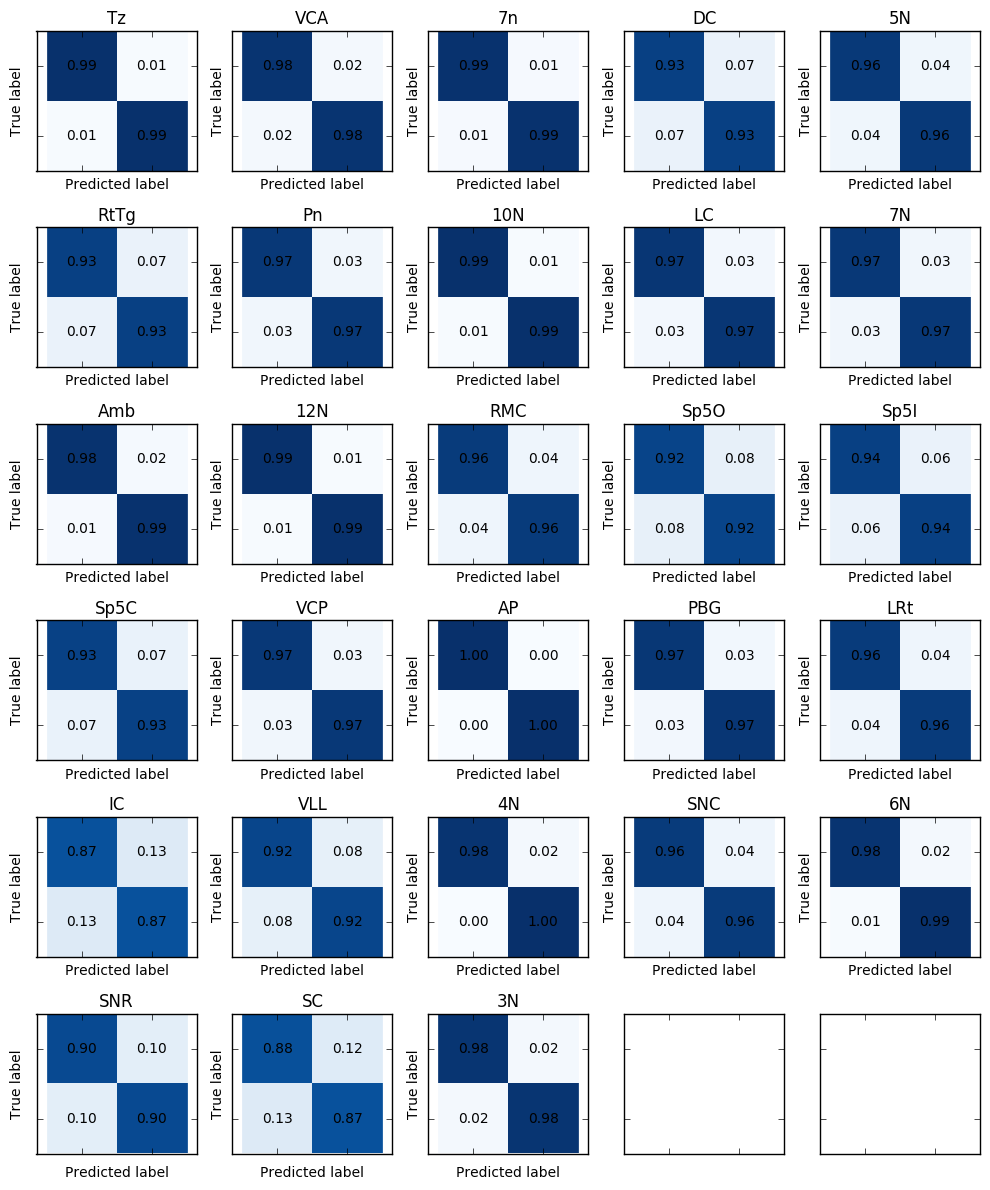

In [24]:
# Compute training accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
    if setting in [1, 3, 4, 5, 6, 7]:
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
    elif setting == 2:
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]            
        for surr_l in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_l)
            if c in labels_found:
                neg_classes.append(c)
    elif setting in [8,9]:
        neg_classes = [structure + '_negative']
    else:
        sys.stderr.write('Setting is not recognized.\n')

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
#     neg_distances = np.concatenate([distances_to_structures[neg_class][label] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
    
    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    clf = clf_allClasses[structure]
    
    probs = clf.predict_proba(train_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in train_labels], soft=True)
    
    acc_all_structures[structure] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(structure)s'% {'structure':structure},
                          labels=['',''],
#                           labels=[label, convert_to_surround_name(label)],
                         axis=axes[i])
#     plt.show();

plt.tight_layout()

In [25]:
print 'training accuracy:', np.mean(acc_all_structures.values())

training accuracy: 0.957362878821


In [ ]:
# visualize training patches

patches = extract_patches_given_locations_multiple_sections(sampled_addresses['AP'], 'grid_index')
display_images_in_grids(patches, 5)

patches = extract_patches_given_locations_multiple_sections(sampled_addresses['AP_surround'], 'grid_index')
display_images_in_grids(patches, 5, titles=sampled_addresses['AP_surround'])

# Visualize a patch in context

patch_size, stride, _, _ = get_default_gridspec('MD589')
grid_locations = grid_parameters_to_sample_locations(get_default_gridspec('MD589'))
viz = patch_boxes_overlay_on('original', 8, 
                       [grid_locations[44453]],
                      patch_size=patch_size,
                      stack='MD589',
                       sec=219)
display_image(viz)